# tNQS for Tranverse Field Ising Model in 1D

This notebook deals with time-dependent problems in Quantum Many-Body Physics. Based on [Van der Walle, Anka et al. [2025]](https://iopscience.iop.org/article/10.1088/2632-2153/ae0f39/meta), we will consider an explicitly time-dependent NQS $\psi_\theta(\sigma, t)$ and optimise the time-independent parameter $\theta$. This differs from methods that evolve the time-dependent parameter $\theta (t)$ to introduce time dependence into the equation. 

The layout of the Architecture:
- Scalar time is passed through an encoder to give a time embedding
- A sequence of spins is passed through a decoder to give a lattice embedding
- Both of these are then fed through an autoregressive decoder, which returns the logits and the phase, which will then be used to model the wave function.
- The weights of the encoder, autoregressive and causal decoder are updated based on a custom loss function.

### 0. Importing the necessary libraries

In [1]:
import os
import math
import numpy as np
import tensorflow as tf
from keras import layers, Model, Sequential
from keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import tqdm

2025-11-26 17:14:10.363700: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 17:14:10.391373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-26 17:14:10.391404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-26 17:14:10.392788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-26 17:14:10.397684: I tensorflow/core/platform/cpu_feature_gua

### 1. Defining the Hamiltonian of the 1D Transverse Field Ising Model

The function `TFIM1D` initialises and describes the calculation of the interaction energy for periodic and open boundary conditions. The Hamiltonian of the system is given as: $$H = - J \sum_{\langle i,j \rangle} \sigma_i^z\sigma_j^z -h\sum_i\sigma_i^x. \tag{1}$$
The transverse field part of the Hamiltonian is off-diagonal and is handled separetly.

In [2]:
class TFIM1D:
    def __init__(self, N, J, h, periodic=False):
        self.N = N                  #Lattice Size   
        self.J = float(J)           #Interaction Coefficient
        self.h = float(h)           #Transverse Field
        self.periodic = periodic

    def diag_energy(self, s):
        #For Periodic Case
        if self.periodic:
            s_shift = tf.roll(s, shift=-1, axis=1) 
            zz = tf.reduce_sum(s * s_shift, axis=1) 
        #For Open Boundary Conditions
        else:
            zz = tf.reduce_sum(s[:, :-1] * s[:, 1:], axis=1) #open boundary conditions
        return -self.J * zz  # shape (batch,)

### 2. Encoder: Scalar Time into a Time Embedding Vector

`build_time_encoder` converts scalar physical time into a learnable high-dimensional embedding. An input layer with one neuron takes in the scalar time value, which is then passed into a fully connected network with 128 neurons and subsequently reduced to 64 neurons. 64 Neurons is then the dimension of the embedding vector and has been kept constant throughout the network.

In [3]:
def build_time_encoder(time_dim=64):
    return Sequential([
        layers.Input(shape=(1,), dtype=tf.float32),
        layers.Dense(128, activation='relu'),
        layers.Dense(time_dim, activation='relu'),
    ], name='time_encoder') #the model is callable as time_encoder
    

### 3. Causal Decoder: Exchanging Positional and Time Context

Similar to Natural Language Models (NLMs) here, we sequentially predict the configuration of the next spin on the lattice and also exchange the positional and time "context" of the spins. The `CausalTransformerDecoder` function utilises self-attention to exchange positional context and then employs cross-attention to exchange temporal context using the time-embedding vector. The self-attention used here is masked, so that previous spins do not have access to future configurations that have not yet been predicted. The embeddings are passed through layers of fully connected feed-forward networks to expand the feature space by accounting for non-linearities and to help represent complex entanglement patterns. 

The flow of data in the Causal Decoder:

Sequence Embedding $\rightarrow$ Masked Self-Attention $\rightarrow$ Normalize(Sequence Embedding + Self-Attention Output) & Time Embedding $\rightarrow$ Cross Attention $\rightarrow$ Feed Forward Network $\rightarrow$ output.

Description of the variables:
- d_model: Embedding/Hidden Dimension (will be the same as the Encoder)
- num_heads: Number of Heads of Attention

In [4]:
class CausalTransformerDecoder(tf.keras.layers.Layer):
    # Used during training to model the wavefunction amplitudes for entire spin configurations at once using masked self-attention
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        
        super().__init__()
        #masked self-attention: allows each spin position to attend to previous spins
        self.self_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=dropout)
        # normalises activations for stable training
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        #feed forward neural network
        self.ffn = Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model),
        ])
        #second normalisation layer
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        # cross-attention to time context (memory)
        # it lets the transformer use a time embedding as "context" that influences config probab
        self.cross_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=dropout)
        self.norm3 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, x, memory, training=False):
        batch, N, d = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        i = tf.range(N)[:, None]
        j = tf.range(N)[None, :]
        causal_mask = tf.cast(i >= j, tf.bool)  # (N,N)
        
        # self-attention (causal)
        att_output = self.self_att(query=x, value=x, key=x, attention_mask=causal_mask)
        x2 = self.norm1(x + att_output) #Embedded Sequence with positional context
        
        # cross-attention to memory (expand memory to length-1)
        # The attention layer expects a shape of (batch, N, dim) 
        memory_expanded = tf.expand_dims(memory, axis=1)  # (batch,1,d)
        cross_out = self.cross_att(query=x2, value=memory_expanded, key=memory_expanded)
        x3 = self.norm3(x2 + cross_out) #Embedded Sequence with positonal and time context
        
        # feed-forward
        ff = self.ffn(x3)
        out = self.norm2(x3 + ff)
        return out

### 4. Autoregressive Decoder

The autoregressive decoder uses multiple-layer decoder blocks to process sequence and time embeddings, learning a parametrisation of the wavefunction. The output of these decoder blocks is then fed into two heads:
- `next_spin_head`: projects the embedding onto either of the spin configurations ($\pm 1$).
- `phase_head`: maps the position embeddings to a single scalar per batch element. The dimension is first halved and then output as a scalar.
  
The autoregressive decoder is invoked in the loop, which sequentially generates spin configurations one lattice point at a time and works something like this:
$$p(s,t) = \prod_{i=1}^{N} p(s_i|s_{<i},t) = \text{autoregressive decoder}(s, \text{time encoder}(t))$$


In [5]:
class AutoregressiveDecoder(Model):
    def __init__(self, N, d_model, num_heads, nlayers):
        super().__init__()
        self.N = N #Number of spins
        self.d_model = d_model #Embedding dimension throughtout the network
        
        #Token embeddings: 0=start, 1->spin -1, 2->spin +1
        self.token_embed = layers.Embedding(input_dim=3, output_dim=d_model) #Maps discrete tokens id to a d-dimensional vector
        self.pos_embed = layers.Embedding(input_dim=N, output_dim=d_model) #Adds learned positional information to the embedding

        #Adds Multiple Causal Decoders layers
        self.decoder_blocks = [CausalTransformerDecoder(d_model=d_model, num_heads=num_heads, d_ff=d_model*4) for _ in range(nlayers)]

        #Projects each position's final embedding to 2 logits
        self.next_spin_head = layers.Dense(2)   #logits for { -1, +1 } per position

        #Pools the position embeddings into a single vector (later) and maps it to a single real number (phase) per batch element.
        self.phase_head = Sequential([layers.Dense(d_model//2, activation='relu'), layers.Dense(1)])  #outputs scalar phase per batch

    def call(self, time_context, tokens=None, training=False):
        # time_context: is the encoded time embedding for each element of the batch. (batch, d_model)
        # tokens: input sequence of token ids (batch, N) int token ids; if None, we provide START tokens for each position
        batch = tf.shape(time_context)[0]
        
        if tokens is None:
            #If no tokens are provided, create (B, N) tensor filled with zeros (token id 0), meaning every position currently has the START token.
            tokens = tf.zeros((batch, self.N), dtype=tf.float32)  # START tokens
        else:
            # ensure integer tokens
            tokens = tf.cast(tokens, tf.float32)

        #A vector with position and spin information is then pushed through the entire blocks of the decoder.
        
        pos_ids = tf.range(self.N)[tf.newaxis, :]  # shape (1,N)
        tok_emb = self.token_embed(tokens) + self.pos_embed(pos_ids)  # (batch,N,d)
        x = tok_emb #Has information about spins and their positions

        #Pass the full sequence through each causal transformer block
        for blk in self.decoder_blocks:
            x = blk(x, time_context, training=training)

        #Linear projection per position to get logits for the 2 possible spin values
        logits = self.next_spin_head(x)  # (batch,N,2)

        #Pool position embeddings by mean across N to get (B, D)
        pooled = tf.reduce_mean(x, axis=1)  # (batch,d)
        #ßphase_head maps (B, D) → (B, 1), squeeze → (B,)
        phase = tf.squeeze(self.phase_head(pooled), axis=-1)  # (batch,)
        return logits, phase

### 5. Tokenization Functions

Similar to NLMs where text is tokenized according to some tokenization scheme here, the lattice is tokenized. Each spin in tokenized and assigned an ID as follows:
- -1 $\rightarrow$ 1
- 1 $\rightarrow$ 2

In [6]:
def spins_to_tokens_tf(s):
    # s: tf.Tensor in {-1,+1}
    return tf.cast((s + 1)//2 + 1, tf.float32)

In [7]:
def tokens_to_spins_tf(tokens):
    # tokens: 1-> -1, 2-> +1
    idx = tf.cast(tokens, tf.int32) - 1  # 0/1
    spins = tf.cast(idx * 2 - 1, tf.floast32)  # 0->-1, 1->+1
    return spins

### 6. Wavefunction Calculation

The `compute_logprob_and_phase` function runs the decoder to obtain the logits and phase which it then converts into probability for every position. The probability and phase from this function is used for the calculations of the wave function. `logp_sum` is  the following operation:
$$\log p(s,t) = \sum_{i=1}^{N} \log p(s_i|s_{<i},t). \tag{2}$$

This is exactly the autoregressive probability which will then be used for the wavefunction.

In [8]:
def compute_logprob_and_phase(decoder, time_context, s):
    #s: tf.Tensor shape (batch,N) values -1/+1
    tokens = spins_to_tokens_tf(s) #The lattice is tokenized 
    logits, phase = decoder(time_context, tokens, training=False) #Calling the autoregessive decoder to give the logits and phase 
    logp = tf.nn.log_softmax(logits, axis=-1) #This converts logits → normalized log-probabilities (batch, N, 2)

    #Select per-position log probability
    #idx: 0 for -1, 1 for +1
    idx = tf.cast((s + 1)//2, dtype=tf.float32)
    # gather per-position
    idx_onehot = tf.one_hot(tf.cast(idx, tf.int32), depth=2, dtype=tf.float32)
    #When multiplied with the decoder’s log-probabilities (batch, N, 2) and summed, it selects the log-probability of the correct spin at each position
    per_pos_logp = tf.reduce_sum(logp * idx_onehot, axis=-1)  #(batch,N)
    logp_sum = tf.reduce_sum(per_pos_logp, axis=1)  #(batch,)
    return logp_sum, phase  #logp (real) and phase (real)

`psi_fn_factory` is crucial because it's here where we use scalar time $t$ and sequence $s$ to generate a time-dependent wave function of the form:
$$\psi(s,t) = \sqrt{p(s,t)} e^{i\phi(t) \tag{3}}$$

In [9]:
def psi_fn_factory(decoder, time_encoder):
    def psi_fn(s, t):
        #s: spin configurations, each entry -1 or +1. tf.Tensor (batch,N) values -1/+1
        #t: times at which the wavefunction must be evaluated. tf.Tensor (batch,1) float32

        #This takes the scalar time and produces a vector embedding
        time_enc = time_encoder(t)  #(batch, d)
        
        logp, phase = compute_logprob_and_phase(decoder, time_enc, s)
        amp = tf.exp(0.5 * logp)  #sqrt probability (positive real)

        #Using Euler's phase
        real = amp * tf.cos(phase)
        imag = amp * tf.sin(phase)
        return tf.complex(real, imag)  # (batch,)
    return psi_fn #complex object

### 7. Sampling 

Generates spin configurations from the autoregressive transforer model and it does this sequenialy, one spin at a time, just like NLMs. `sample_from_model` uses an initial sequence of all spins poinitng down and then based on decoder's output it chooses whether to flip it or keep it as it is (doing it this way because tensors are immutable in TensorFlow).

In [10]:
def sample_from_model(decoder, time_encoder, t_scalar, n_samples):
    #t_scalar: Python scalar or tf scalar
    batch = n_samples
    t = tf.fill([batch, 1], tf.cast(t_scalar, tf.float32))
    time_enc = time_encoder(t)  #(batch,d)
    tokens = tf.zeros([batch, decoder.N], dtype=tf.int32)  #start tokens
    samples = tf.fill([batch, decoder.N], -1)  #placeholder -1 ints

    #The loop runs over all positions to predict the spin configuration at each site.
    for pos in range(decoder.N):
        logits, _ = decoder(time_enc, tokens, training=False)  # (batch,N,2)
        logits_pos = logits[:, pos, :]                         # (batch,2)
        
        #idx draws a random sample from the categorical distribution of logits
        idx = tf.squeeze(tf.random.categorical(logits_pos, num_samples=1), axis=1)  # (batch,)
        #The values are mapped to either  1 or 0
        idx = tf.cast(idx, tf.int32)  # 0 or 1
        spin = tf.cast(idx * 2 - 1, tf.int32)  # -1 or +1
        token_id = idx + 1                     # 1 or 2
        
        #Scatter update the samples and tokens
        batch_idx = tf.range(batch, dtype=tf.int32)
        scatter_indices = tf.stack([batch_idx, tf.fill([batch], pos)], axis=1)
        samples = tf.tensor_scatter_nd_update(samples, scatter_indices, spin)
        tokens = tf.tensor_scatter_nd_update(tokens, scatter_indices, token_id)
    return samples

In [11]:
def complex_sq_norm(z):
    return tf.math.real(z * tf.math.conj(z))  # returns real-valued |z|^2

### 8. Defining the Custom Loss Function

The loss function is described discretely as:
$$\mathcal{L} = \frac{1}{N_{batch}} \sum_s |i\partial_t{\psi_\theta(s,t)} - \hat{H}\psi_\theta(s,t)|^2. \tag{3}$$

It computes the residual of the time-dependent Schrödinger equation for the TFIM system using the model wavefunction. This residual acts as a loss function for training the neural network to approximate the correct quantum dynamics. $\hat{H}\psi_\theta(s,t)$ is computed by calculating the Hamiltonian in Eq. (1) and the time derivatives of the wavefunction are calculated using `tf.GradientTape`. The difference between these values is the loss value, which is then averaged over the tme batchs.

In [12]:
def compute_residual_loss(decoder, time_encoder, model_psi, ham, t_batch, n_samples):
    #t_batch: tf.Tensor shape (times_per_batch,) floats
    losses = []
    for t_scalar in tf.unstack(t_batch):
        #Uses the autoregressive decoder to generate n_samples of lattice configurations according to \ψ(t)\^2
        s = sample_from_model(decoder, time_encoder, t_scalar, n_samples)  # (n_samples, N) ints -1/+1
        s = tf.cast(s, tf.float32)
        # create t input with gradient tracing
        t_in = tf.fill([n_samples, 1], t_scalar)
        t_in = tf.Variable(tf.fill([n_samples, 1], t_scalar), dtype=tf.float32)  # watchable
        
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t_in)
            psi = model_psi(s, t_in)  # complex tensor (n_samples,)
            
            # compute H psi
            E_diag = ham.diag_energy(s)  # Energy Contribution from the spin interaction(n_samples,)
            #Compute sum over single-spin flipped psi
            sum_neighbors = tf.zeros_like(psi)
            for i in range(ham.N):
                s_flipped = tf.concat([s[:, :i], -s[:, i:i+1], s[:, i+1:]], axis=1)
                sum_neighbors += model_psi(s_flipped, t_in)
            #Convert E_diag (real) to complex, same dtype as psi
            E_diag_c = tf.cast(E_diag, psi.dtype)
            h_c = tf.cast(ham.h, psi.dtype)
            Hpsi = E_diag_c * psi - h_c * sum_neighbors
            #Split ψ into real and complex parts
            psi_real = tf.math.real(psi)
            psi_imag = tf.math.imag(psi)
            #Compute the gradients
            grad_real = tape.gradient(tf.reduce_sum(psi_real), t_in)
            grad_imag = tape.gradient(tf.reduce_sum(psi_imag), t_in)
        #flattening the gradients to form the derivative of the wavefunction
        grad_real_flat = tf.reshape(grad_real, [-1])
        grad_imag_flat = tf.reshape(grad_imag, [-1])
        dpsi_dt = tf.complex(grad_real_flat, grad_imag_flat)
        i_dpsi = tf.complex(-tf.math.imag(dpsi_dt), tf.math.real(dpsi_dt)) #Mutliplying wiht the complex i for correct form
        r = i_dpsi - Hpsi
        loss_t = tf.reduce_mean(complex_sq_norm(r))
        losses.append(loss_t)
        del tape
    return tf.reduce_mean(tf.stack(losses)) # A scalar loss value is returned

A function which computes the magnetization across the batches

In [13]:
#Computes the magnetisation
def compute_magnetization(samples, N):
    samples = tf.cast(samples, tf.float32)
    m_per_sample = tf.reduce_sum(samples, axis=1) / float(N)
    return tf.reduce_mean(m_per_sample)

### 9. Training Loop

For each training batch, pick `times_per_batch` number of different times, and for each time, generate `samples_per_time` number of independent spin configuration. So the mdoel will generate a total of `times_per_batch` $\times$ `samples_per_time` samples per training batch.

In [14]:
#Architecture Hyperparameters
N=10                            #The size of the lattice
time_dim=64                     #Dimension of the Time Embedding (also the output dimension of the Time Encoder)
d_model=64                      #Dimension of the Embeddings across the Model
num_heads=4                     #Number of Heads of Attention in Causal Decoder
nlayers=2                       #Number of Decoder Blocks to be used in the Autoregressive Decoder

#Values for the TFIM
J=1.0
h=-1.0

#Training Parameters of the Model 
n_epochs=100                    #Number of Training Epochs
times_per_batch=5               #Number of Batches of Configurations used for Training
samples_per_time=128            #Number of Spin Configurations sampled at each time step to estimate the residual loss
T_max=10.0                      #The Maximum Amount of Physical Time the Model is Trained for
alpha_ic=5.0                  #Controls how strongly the training enforces the initial-condition constraint
lr=5e-4                         #Learning Rate

# Initialisation for the Training Loop
tf.random.set_seed(1)
ham = TFIM1D(N=N, J=J, h=h, periodic=True)
time_encoder = build_time_encoder(time_dim=time_dim)
decoder = AutoregressiveDecoder(N=N, d_model=d_model, num_heads=num_heads, nlayers=nlayers)
model_psi = psi_fn_factory(decoder, time_encoder)

2025-11-26 17:14:13.932018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-26 17:14:13.952887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-26 17:14:13.953052: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[Van der Walle, Anka et al. [2025]](https://iopscience.iop.org/article/10.1088/2632-2153/ae0f39/meta) enforces the initial condition by adding a physical layer that concatenates the initial condition with the output of the autoregressive decoder. Instead of this, we define $\psi(s_0,0)$ using an initial physical condition `s0` (all spins pointing up) and `t0` such that $t=0$. These initial conditions are then enforced via the loss function $$\mathcal{L} = \mathcal{L}_{residuals} + \alpha_{IC}\mathcal{L}_{IC}. \tag{4}$$

This means the model MUST learn the initial condition because it is directly optimised. This is a loss-level enforcement, not an architecture-level enforcement.

Some drawbacks of the method used here:
- The value $\alpha_{IC}$ sets how biased the model should be towards the initial condition. Hence, choosing a very high value doesn't allow the configurations to explore much beyond the initial condition. The value of $\alpha_{IC}$ should be mindfully set

In [15]:
#The Training Loop

# Initialising the layers of the Encoders and also does a sanity check whether the layer is fully dense 
for layer in time_encoder.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        layer.kernel.assign(tf.random.normal(layer.kernel.shape, stddev=1e-4))                 #Randomly assings weights with a very low standard deviation
        if layer.bias is not None:
            layer.bias.assign(tf.zeros_like(layer.bias))                                       #Sets the Biases to zero
            
_ = decoder(time_encoder(tf.zeros([1,1], dtype=tf.float32)), tf.zeros([1,N], dtype=tf.int32))  #Runs a dummy forward pass through the decoder to initialise the weights of the dense layer

#Describing the weights and biases for the phase and next_spin head of the autoregressive decoder

#To favour the initial condition of all spins being pointed up, the bias of spin -1 is set very low and for spin +1 is set very high. With training these biases change.
decoder.next_spin_head.bias.assign(tf.constant([-8.0, 8.0], dtype=tf.float32))                 

#Intializing the weights and the biases for the phase_head
final_phase = decoder.phase_head.layers[-1]
final_phase.bias.assign(tf.zeros_like(final_phase.bias))                                        #Biases are set as zero
final_phase.kernel.assign(tf.random.normal(final_phase.kernel.shape, stddev=1e-4))              #The weights are taken from a normal distribution of small variance

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

#Supervised initial condition: all spins up (values +1)
s0 = tf.ones([1, N], dtype=tf.float32)
t0 = tf.constant([[0.0]], dtype=tf.float32)
psi_target = tf.constant([1.0 + 0.0j], dtype=tf.complex64)

loss_hist, mag_hist, time_hist = [], [], []
pbar = tqdm.tqdm(range(n_epochs), desc="Training", unit="epoch")

for epoch in pbar:
    #Random times between 0 and T_max
    t_batch = tf.random.uniform([times_per_batch], minval=0.0, maxval=T_max, dtype=tf.float32)
    with tf.GradientTape() as tape:
        #Residual loss (physics)
        loss_res = compute_residual_loss(decoder, time_encoder, model_psi, ham, t_batch, samples_per_time)
        #Supervised IC loss at t=0 for all-up state
        psi0_pred = model_psi(s0, t0)  # complex (1,)
        #Loss from the Initial Condition
        loss_ic = tf.reduce_mean(complex_sq_norm(psi0_pred - psi_target))
        loss_total = loss_res + alpha_ic * loss_ic
    train_vars = decoder.trainable_variables + time_encoder.trainable_variables
    grads = tape.gradient(loss_total, train_vars)
    optimizer.apply_gradients(zip(grads, train_vars))
    #Sample at Earliest time in Batch for monitoring Magnetisation
    samples = sample_from_model(decoder, time_encoder, t_batch[0], samples_per_time)
    mag = compute_magnetization(samples, N)
    loss_hist.append(float(loss_total.numpy()))
    mag_hist.append(float(mag.numpy()))
    time_hist.append(float(t_batch[0].numpy()))
    pbar.set_postfix({"loss": float(loss_total.numpy()), "mag": float(mag.numpy())})

/software/opt/el_9/x86_64/python/3.12-2024.10/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
Training:   0%|          | 0/100 [00:00<?, ?epoch/s]/software/opt/el_9/x86_64/python/3.12-2024.10/lib/python3.12/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (128, 4, 10, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Training: 100%|██████████| 100/100 [12:16<00:00,  7.36s/epoch, loss=0.621, mag=0.5] 


### 10. Plotting the Training Dynamics

Plotting the loss across Epochs

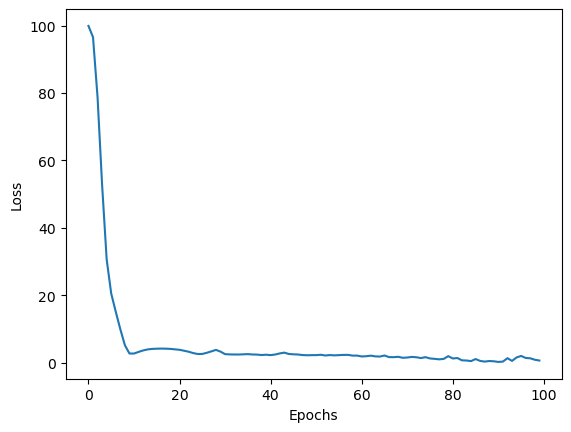

In [16]:
plt.plot(loss_hist)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss_Plot.png')
plt.show()

The Magnetization across epochs

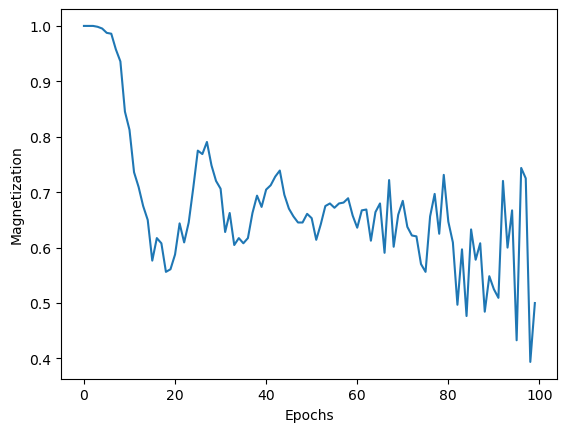

In [17]:
plt.plot(mag_hist)
plt.xlabel("Epochs")
plt.ylabel("Magnetization")
plt.savefig('Magentization_Plot.png')
plt.show()